<a href="https://colab.research.google.com/github/syedirfan04/CS418-Project/blob/main/418_clean_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Replace 'aviation_project' with your desired folder name
drive_folder = "/content/drive/MyDrive/aviation_project"
os.makedirs(drive_folder, exist_ok=True)


In [ ]:
import shutil
import glob

# Copy all CSV files from current working directory to Drive
local_files = glob.glob("/content/*.csv")

for file in local_files:
    filename = os.path.basename(file)
    dest_path = os.path.join(drive_folder, filename)
    shutil.copy(file, dest_path)
    print(f"Saved {filename} to Google Drive")


Saved bts_2023_6.0.csv to Google Drive
Saved bts_with_airports.csv to Google Drive
Saved bts_combined_cleaned.csv to Google Drive
Saved bts_2023_08.csv to Google Drive
Saved T_T100D_SEGMENT_ALL_CARRIER.csv to Google Drive
Saved bts_2023_09.csv to Google Drive
Saved bts_2023_06.csv to Google Drive
Saved openflights_airports.csv to Google Drive


# Load the T-100 Domestic Segment Data

In [ ]:
import pandas as pd

# Load your downloaded BTS T-100 Domestic Segment file
bts_raw = pd.read_csv('/content/T_T100D_SEGMENT_ALL_CARRIER.csv')
print(f"Loaded {len(bts_raw):,} rows")
bts_raw.head()


Loaded 263,948 rows


,PASSENGERS,UNIQUE_CARRIER,CARRIER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,YEAR,MONTH
0,0.0,02Q,02Q,MCO,"Orlando, FL",MIA,"Miami, FL",2025,1
1,0.0,02Q,02Q,MIA,"Miami, FL",PAE,"Everett, WA",2025,2
2,0.0,02Q,02Q,PAE,"Everett, WA",KOA,"Kona, HI",2025,5
3,0.0,0CQ,0CQ,MCO,"Orlando, FL",OPF,"Miami, FL",2025,5
4,0.0,0CQ,0CQ,SUN,"Sun Valley/Hailey/Ketchum, ID",ACK,"Nantucket, MA",2025,7


# Clean and Prepare the BTS Data

In [ ]:
# Keep only the essential columns
bts_cleaned = bts_raw[['YEAR', 'MONTH', 'ORIGIN', 'DEST', 'PASSENGERS']].copy()

# Drop rows with missing or 0 passengers
bts_cleaned = bts_cleaned.dropna(subset=['PASSENGERS'])
bts_cleaned = bts_cleaned[bts_cleaned['PASSENGERS'] > 0]

print(f"Cleaned: {len(bts_cleaned):,} rows")
bts_cleaned.head()


Cleaned: 221,240 rows


,YEAR,MONTH,ORIGIN,DEST,PASSENGERS
42708,2025,7,BRO,SUN,1.0
42709,2025,4,FAR,PGA,1.0
42710,2025,4,PGA,APA,1.0
42711,2025,4,BCT,TPA,1.0
42712,2025,4,BCT,TPA,1.0


# Merge with Airport Metadata

In [ ]:
# Load airport data
airports_df = pd.read_csv(
    "/content/openflights_airports.csv",
    header=None,
    usecols=[2, 3, 4, 6, 7],
    names=["City", "Country", "IATA", "Latitude", "Longitude"],
    dtype=str
)

# Clean and format
airports_df = airports_df[airports_df["IATA"].notnull()]
airports_df = airports_df[airports_df["IATA"] != "\\N"]
airports_df['IATA'] = airports_df['IATA'].str.upper()

bts_cleaned['ORIGIN'] = bts_cleaned['ORIGIN'].str.upper()
bts_cleaned['DEST'] = bts_cleaned['DEST'].str.upper()

# Merge ORIGIN
bts_merged = bts_cleaned.merge(
    airports_df,
    how="left",
    left_on="ORIGIN",
    right_on="IATA"
).rename(columns={
    "City": "ORIGIN_CITY",
    "Country": "ORIGIN_COUNTRY",
    "Latitude": "ORIGIN_LAT",
    "Longitude": "ORIGIN_LON"
}).drop(columns=["IATA"])

# Merge DEST
bts_merged = bts_merged.merge(
    airports_df,
    how="left",
    left_on="DEST",
    right_on="IATA"
).rename(columns={
    "City": "DEST_CITY",
    "Country": "DEST_COUNTRY",
    "Latitude": "DEST_LAT",
    "Longitude": "DEST_LON"
}).drop(columns=["IATA"])


print(f"Merged: {len(bts_merged):,} rows")
bts_merged.head()


Merged: 221,240 rows


,YEAR,MONTH,ORIGIN,DEST,PASSENGERS,ORIGIN_CITY,ORIGIN_COUNTRY,ORIGIN_LAT,ORIGIN_LON,DEST_CITY,DEST_COUNTRY,DEST_LAT,DEST_LON
0,2025,7,BRO,SUN,1.0,Brownsville,United States,25.90679931640625,-97.4259033203125,Hailey,United States,43.50439835,-114.2959976
1,2025,4,FAR,PGA,1.0,Fargo,United States,46.92070007324219,-96.81580352783203,Page,United States,36.92610168,-111.447998
2,2025,4,PGA,APA,1.0,Page,United States,36.92610168,-111.447998,Denver,United States,39.57009888,-104.848999
3,2025,4,BCT,TPA,1.0,Boca Raton,United States,26.3784999847,-80.1076965332,Tampa,United States,27.975500106811523,-82.533203125
4,2025,4,BCT,TPA,1.0,Boca Raton,United States,26.3784999847,-80.1076965332,Tampa,United States,27.975500106811523,-82.533203125


# Save Cleaned & Merged Data

In [ ]:
bts_merged.to_csv('/content/bts_with_airports.csv', index=False)
print("Saved merged dataset as bts_with_airports.csv")


Saved merged dataset as bts_with_airports.csv


# Filter to U.S. Domestic Routes

In [ ]:
# Filter for U.S. domestic routes
us_domestic = bts_merged[
    (bts_merged['ORIGIN_COUNTRY'] == 'United States') &
    (bts_merged['DEST_COUNTRY'] == 'United States')
].copy()

print(f"🇺🇸 U.S. Domestic Routes: {len(us_domestic):,} rows")
us_domestic.head()


🇺🇸 U.S. Domestic Routes: 208,962 rows


,YEAR,MONTH,ORIGIN,DEST,PASSENGERS,ORIGIN_CITY,ORIGIN_COUNTRY,ORIGIN_LAT,ORIGIN_LON,DEST_CITY,DEST_COUNTRY,DEST_LAT,DEST_LON
0,2025,7,BRO,SUN,1.0,Brownsville,United States,25.90679931640625,-97.4259033203125,Hailey,United States,43.50439835,-114.2959976
1,2025,4,FAR,PGA,1.0,Fargo,United States,46.92070007324219,-96.81580352783203,Page,United States,36.92610168,-111.447998
2,2025,4,PGA,APA,1.0,Page,United States,36.92610168,-111.447998,Denver,United States,39.57009888,-104.848999
3,2025,4,BCT,TPA,1.0,Boca Raton,United States,26.3784999847,-80.1076965332,Tampa,United States,27.975500106811523,-82.533203125
4,2025,4,BCT,TPA,1.0,Boca Raton,United States,26.3784999847,-80.1076965332,Tampa,United States,27.975500106811523,-82.533203125


# Show Top 10 Busiest Routes (by Passenger Volume)

In [ ]:
# Group by route and sum passenger counts
route_summary = (
    us_domestic
    .groupby(['ORIGIN', 'DEST'], as_index=False)['PASSENGERS']
    .sum()
    .sort_values(by='PASSENGERS', ascending=False)
    .head(10)
)

print("📈 Top 10 Busiest U.S. Domestic Routes:")
route_summary


📈 Top 10 Busiest U.S. Domestic Routes:


,ORIGIN,DEST,PASSENGERS
8509,LAX,JFK,828350.0
7845,JFK,LAX,813518.0
872,ATL,MCO,813036.0
9260,MCO,ATL,810616.0
8578,LAX,SFO,784040.0
8835,LGA,ORD,770346.0
11398,ORD,LGA,766807.0
14363,SFO,LAX,760373.0
8329,LAS,LAX,731459.0
8513,LAX,LAS,713535.0


# Visualize as a Network Graph

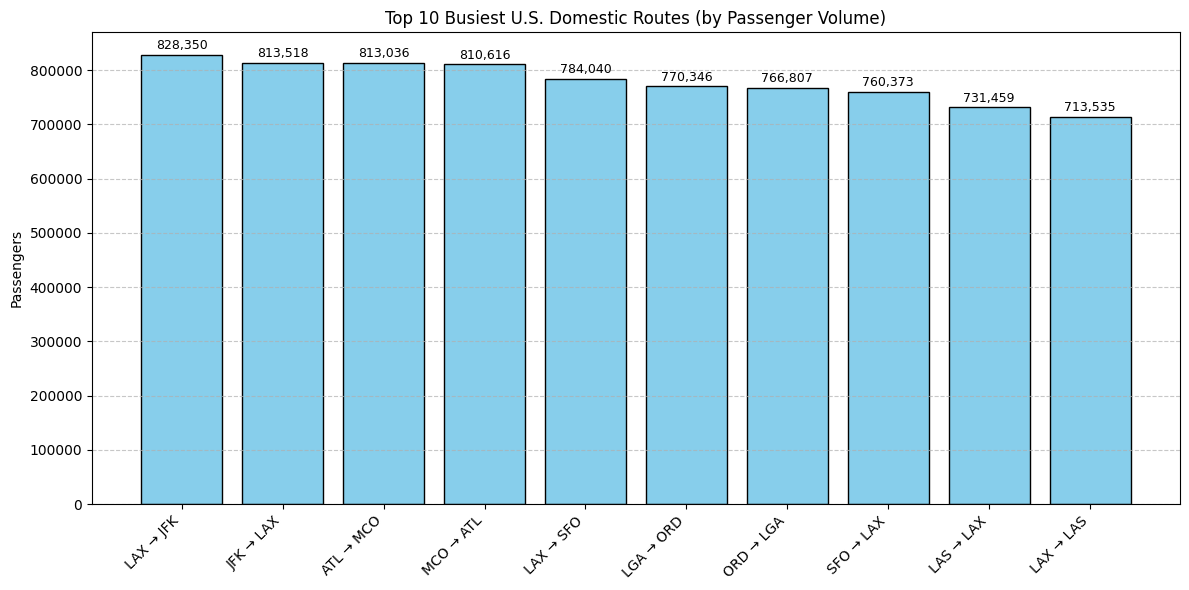

In [ ]:
import matplotlib.pyplot as plt

# Create a new column for route labels like "JFK → LAX"
route_summary['ROUTE'] = route_summary['ORIGIN'] + " → " + route_summary['DEST']

# Sort by passenger volume just in case
route_summary = route_summary.sort_values(by='PASSENGERS', ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(route_summary['ROUTE'], route_summary['PASSENGERS'], color='skyblue', edgecolor='black')

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5000, f'{int(yval):,}', ha='center', va='bottom', fontsize=9)

# Labels and title
plt.xticks(rotation=45, ha='right')
plt.ylabel("Passengers")
plt.title("Top 10 Busiest U.S. Domestic Routes (by Passenger Volume)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
